# Higgs Boson detection

In [29]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from expansion import *
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.display import display
from proj1_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data parsing/cleaning

In [30]:
pri0_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]
pri1_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]

In [60]:
DATA_TRAIN_PATH = '../data/train.csv'
hb = pd.read_csv(DATA_TRAIN_PATH, sep=',')
pd.options.display.max_columns = None
hb = hb.drop(['Id'], 1)

def cleanDataSet(dataset):
    #dataset = add_DER_mass_indicator(dataset)
    dataset_mass_def = dataset[dataset.DER_mass_MMC != -999].copy()
    dataset_mass_not_def = dataset[dataset.DER_mass_MMC == -999].copy()
    dataset_mass_not_def = dataset_mass_not_def.drop(['DER_mass_MMC'],1)
    def splitOnJetNum(dataset, DER_mass_MMC_is_defined):
        dataset = dataset.replace(-999, np.nan)
        if(DER_mass_MMC_is_defined):
            dataset = nonPolyFeatureExpansion(dataset)


        pri0 = dataset[dataset.PRI_jet_num==0].copy()
        pri0 = pri0.drop(pri0_to_drop,1)
        pri0 = pri0.drop(["PRI_jet_num","PRI_jet_all_pt"],1)

        pri1 = dataset[dataset.PRI_jet_num == 1].copy()
        pri1 = pri1.drop(pri1_to_drop,1)
        pri1 = pri1.drop(["PRI_jet_num"],1)

        pri2 = dataset[dataset.PRI_jet_num == 2].copy()
        pri2 = pri2.drop(["PRI_jet_num"],1)

        pri3 = dataset[dataset.PRI_jet_num == 3].copy()
        pri3 = pri3.drop(["PRI_jet_num"],1)

        return [pri0,pri1,pd.concat([pri2,pri3])]
        #return [pri0,pri1,pri2,pri3]
    
    return splitOnJetNum(dataset_mass_def, True) + splitOnJetNum(dataset_mass_not_def, False)
    #return splitOnJetNum(dataset,False)

def extractPredictions(dataset):
    return dataset.Prediction.apply(lambda x: -1 if x == 'b' else 1).to_numpy()

def add_DER_mass_indicator(data):
    data['DER_mass_MMC_present'] = (data.DER_mass_MMC == -999).apply(lambda x : 1 if x else 0)
    return data

def nonPolyFeatureExpansion(data):
    data['Mass_let_tau_sum_pt_ratio'] = data.DER_mass_MMC * data.DER_pt_ratio_lep_tau / (data.DER_sum_pt+1e-10)
    return data

def normalizeDataset(dataset):
    dataset = (dataset - dataset.mean()) / dataset.std()
    dataset = dataset.fillna(0)
    dataset = (dataset - dataset.mean()) / dataset.std()
    return dataset

def normalizeDataset_numpy(dataset):
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis=0)
    dataset = np.nan_to_num(dataset)
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)
    return dataset

def tildaNumpy(X):
    return np.c_[np.ones(X.shape[0]), X]

POLYNOMIAL_EXPANSION_DEGREE = 5

tx = cleanDataSet(hb)
y = []

from sklearn.model_selection import train_test_split
tx_test = []
y_test = []

for idx, dataset in enumerate(tx):
    y_temp = extractPredictions(dataset)
    dataset = dataset.drop(['Prediction'],1)
    tx_temp = tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE)))
    X_train, X_test, y_train, y_test_temp = train_test_split(tx_temp, y_temp, test_size=0.1, random_state=0)    
    
    y.append(y_train)
    tx[idx] = X_train
    tx_test.append(X_test)
    y_test.append(y_test_temp)

In [61]:
from implementations import *

number_of_algorithms = 6

w = []
for i in range(number_of_algorithms):
    w.append([])

initial_w = [np.zeros(txi.shape[1]) for txi in tx]

## Algorithms

In [37]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

### 0. Least squares gradient descent

In [39]:
algorithm = 0
w[algorithm] = []
for i, (yi, txi, wi) in enumerate(zip(tqdm(y), tx, initial_w)):
    local_w, loss = least_squares_GD(yi, txi, wi, 1000, 1e-3)
    w[algorithm].append(local_w)
    print(loss)

0.28866741545340935
0.38855698857060006
0.37529542153121953
0.38374748801607367



### 1. Least squares stochastic gradient descent

In [40]:
algorithm = 1
w[algorithm] = []
for yi, txi, wi in zip(tqdm(y), tx, initial_w):
    local_w, loss = least_squares_SGD(yi, txi, wi, 100000, 1e-3)
    w[algorithm].append(local_w)
    print(loss)

0.2886497657352685
0.3885346476438921
0.37527401038973657
0.38368942684519397



### 2. Least squares

In [41]:
algorithm = 2
w[algorithm] = []
for yi, txi in zip(tqdm(y), tx):
    print("cond " + str(np.linalg.cond(txi.T @ txi)))
    local_w, loss = least_squares(yi, txi)
    w[algorithm].append(local_w)
    print(loss)

cond 3304052329982.5425
0.2721585490443791
cond 5475135819655.621
0.37249096641402485
cond 340026078557.0272
0.3567155826060113
cond 731623006262.9072
0.3600561153528021



### 3. Ridge regression


0.003888155180308085


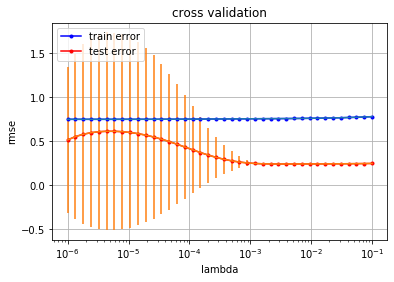


4.641588833612772e-05


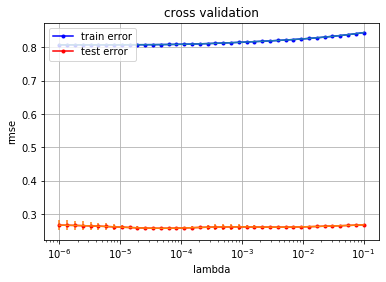


0.00010608183551394483


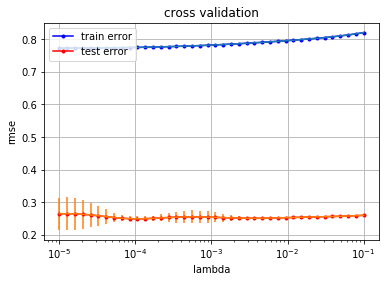


8.376776400682924e-05


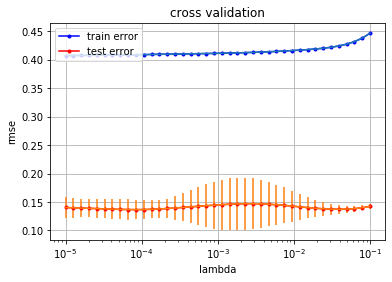


0.0058780160722749115


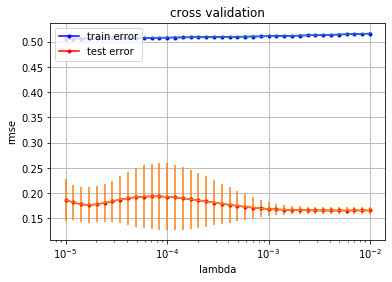


0.011937766417144358


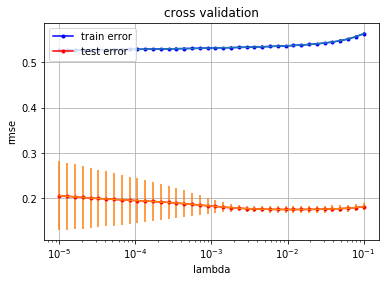

In [85]:
from plots import *

ridge_parameters = []

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""

    x_tr = np.delete(x, k_indices[k], axis=0)
    y_tr = np.delete(y, k_indices[k], axis=0)
    
    x_te = x[k_indices[k]]
    y_te = y[k_indices[k]]
    w, rmse = ridge_regression(y_tr, x_tr, lambda_)
    
    n = y.shape[0]
    loss_tr = rmse
    loss_te = compute_loss_rmse(2*n , compute_e(y_te, x_te, w))
    return loss_tr, loss_te
    
def cross_validation_demo(i):
    seed = 2019
    k_fold = 10
    lambdas = np.logspace(-6, -1, 40)
    '''if i == 0:
        lambdas = np.logspace(-3, -2, 30)
    elif i == 1:
        lambdas = np.logspace(-3, -2, 30)
    elif i == 2:
        lambdas = np.logspace(-4, -3, 30)
    elif i == 3:
        lambdas = np.logspace(-2, -1, 30)
    elif i == 4:
        lambdas = np.logspace(-3, -2, 30)
    elif i == 5:
        lambdas = np.logspace(-2, -1, 30)'''
    if i == 0:
        lambdas = np.logspace(-6, -1, 40)
    elif i == 1:
        lambdas = np.logspace(-6, -1, 40)
    elif i == 2:
        lambdas = np.logspace(-5, -1, 40)
    elif i == 3:
        lambdas = np.logspace(-5, -1, 40)
    elif i == 4:
        lambdas = np.logspace(-5, -2, 40)
    elif i == 5:
        lambdas = np.logspace(-5, -1, 40)
    
    yex = y[i][:,np.newaxis]
    x = tx[i]
    
    # split data in k fold
    k_indices = build_k_indices(yex, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    
    for lambda_ in tqdm(lambdas):
        loss_tr = []
        loss_te = []
        for k in range(k_fold):
            tr, te = cross_validation(yex, x, k_indices, k, lambda_)
            loss_tr.append(tr)
            loss_te.append(te)
        rmse_tr.append(np.mean(loss_tr))
        rmse_te.append(np.mean(loss_te))
        var_tr.append(np.std(loss_tr))
        var_te.append(np.std(loss_te))
    optimal = lambdas[np.argmin(rmse_te)]
    print(optimal)
    ridge_parameters.append(optimal)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, var_tr, var_te)

for i in range(len(tx)):
    cross_validation_demo(i)

In [91]:
algorithm = 3
w[algorithm] = []
for yi, txi, ridge_parameter in tqdm(zip(y, tx, ridge_parameters)):
    local_w, loss = ridge_regression(yi, txi, ridge_parameter)
    w[algorithm].append(local_w)
    print(loss)

0.7572781368621017
0.8082229460128558
0.7745100001622608
0.40892644809575
0.5148967272869694
0.5380006786071643



In [92]:
algorithm = 3
w[algorithm] = []
for yi, txi, ridge_parameter in zip(y, tx, ridge_parameters):
    local_w, loss = ridge_regression(yi, txi, ridge_parameter)
    w[algorithm].append(local_w)
    print(loss)

0.7572781368621017
0.8082229460128558
0.7745100001622608
0.40892644809575
0.5148967272869694
0.5380006786071643


In [93]:
output_algo = 3
accuracy_by_pri = []
for dataset_id in range(len(y_test)):
    accuracy_by_pri.append(accuracy(y_test[dataset_id],w[output_algo][dataset_id],tx_test[dataset_id]))
    
print(calc_weighted_mean(accuracy_by_pri))

0.8153821541415031


### 4. Logistic regression

In [48]:
algorithm = 4
w[algorithm] = []
gamma = 0.1
for yi, txi, wi in zip(tqdm(y), tx, initial_w):
    losses = []
    yi = (yi+1)/2
    local_w, loss = logistic_regression(yi, txi, wi.copy(), 100000, gamma) 
    w[algorithm].append(local_w)
    print(loss)

39417.74586128189
47078.441387778024
30954.151045008985
13896.791943439477



In [49]:
algorithm = 4
w[algorithm] = []
gamma = 0.1
for yi, txi, wi in zip(tqdm(y), tx, initial_w):
    losses = []
    yi = (yi+1)/2
    local_w, loss = logistic_regression(yi, txi, wi.copy(), 100000, gamma) 
    w[algorithm].append(local_w)
    print(loss)

39417.74586128189
47078.441387778024
30954.151045008985
13896.791943439477



### 5. Regularized logistic regression

In [50]:
algorithm = 5
w[algorithm] = []
gamma = 0.1
lambda_ = 0.001
for yi, txi, wi in zip(tqdm(y), tx, initial_w):
    yi = (yi+1)/2
    local_w, loss = reg_logistic_regression(yi, txi, lambda_, wi, 1000, gamma)
    w[algorithm].append(local_w)
    print(loss)

446975.5142691836
537063.442570036
279133.87553108076
144355.1922707886



In [51]:
algorithm = 5
w[algorithm] = []
gamma = 0.1
lambda_ = 0.001
for yi, txi, wi in zip(tqdm(y), tx, initial_w):
    yi = (yi+1)/2
    local_w, loss = reg_logistic_regression(yi, txi, lambda_, wi, 1000, gamma)
    w[algorithm].append(local_w)
    print(loss)

446975.5036449792
537063.4424986583
266678.0360664513
144393.92698440995



## Final evaluation

In [52]:
def accuracy(y_test,w,tx_test):
    return (y_test == predict_labels(w, tx_test).ravel()).sum()/len(y_test)

def calc_weighted_mean(accuracy_by_pri):
    total = 0.
    nbElements = 0.
    for acc, y in zip(accuracy_by_pri, y_test):
        nbElements += len(y)
        total += acc * len(y)
    return total / nbElements

for output_algo in range(number_of_algorithms):
    print("algo " + str(output_algo))
    accuracy_by_pri = []
    for dataset_id in range(len(y_test)):
        accuracy_by_pri.append(accuracy(y_test[dataset_id],w[output_algo][dataset_id],tx_test[dataset_id]))
    
    print(calc_weighted_mean(accuracy_by_pri))

algo 0
0.6930645548356131
algo 1
0.6930645548356131
algo 2
0.7573394128469723
algo 3
0.75765938724902
algo 4
0.7329013678905687
algo 5
0.6930645548356131


In [208]:
len(y_test)

4

### Load test set

In [22]:
DATA_TEST_PATH = '../data/test.csv'

hbt = pd.read_csv(DATA_TEST_PATH, sep=',')
hbt = hbt.drop(['Prediction'], 1)
hbt = hbt.set_index(['Id'])

## Make predictions

In [55]:
output_algo = 4

test_pri = cleanDataSet(hbt)
test_pri_tX = [] # tX arrays to run prediction on
for idx , dataset in enumerate(test_pri):
    test_pri_tX.append( tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE))))
    
def predict(test_pri,test_pri_tX, w):
    for idx, dataset in enumerate(test_pri_tX):
        test_pri[idx]['Prediction'] = predict_labels(w[output_algo][idx],dataset)
    return test_pri

test_prediction = predict(test_pri,test_pri_tX,w)
test_prediction = pd.concat(test_prediction,sort=True)
test_prediction = test_prediction.sort_index()
OUTPUT_PATH = 'predictions.csv'
create_csv_submission(test_prediction.Prediction.keys(), test_prediction.Prediction.values, OUTPUT_PATH)

In [56]:
print(len(test_prediction.Prediction.values))
print(len(test_prediction.Prediction.values[test_prediction.Prediction.values > 0]))

568238
203406


In [15]:
print(w[4][0].shape)

(248,)
